### SuperSpike 

This tutorial implements the SuperSpike learning rule with a simple network prototype with one pre-synaptic neuron and one post-synaptic neuron. The Lava Process Architecture is as shown below:

![SuperSpike_Architecture](SuperSpike_architecture.svg)

In [1]:
import numpy as np

from lava.proc.lif.process import LIF, LearningLIF
from lava.proc.io.source import RingBuffer as SpikeIn
from lava.proc.dense.process import LearningDense, Dense
from lava.proc.dense.models import PyLearningDenseModelFloat
from lava.proc.monitor.process import Monitor

from lava.magma.core.learning.learning_rule import LoihiLearningRule
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi2SimCfg

import time as timing

#### Importing the SuperSpike Learning Rule Wrapper

![SuperSpike](SuperSpike_learning_rule.svg)

In [2]:
from lava.proc.learning_rules.SuperSpike_learning_rule import DoubleExponentialSuperSpikeLoihi

SuperSpike = DoubleExponentialSuperSpikeLoihi(learning_rate="2 ^ -9",
                             pre_synaptic_decay_tau=10,
                             pre_synaptic_rise_tau=5,
                             eligibility_trace_decay_tau="2 ^ -1",
                             eligibility_trace_rise_tau="2 ^ -1",
                             t_epoch=2)

#### Setting Simulation Parameters and Creating Input Spikes

In [3]:
SELECT_TAG = "floating_pt"

In [4]:
# ============================================================================================================
# PARAMS
# ============================================================================================================
# General Params
num_rounds = 20
num_steps_single_presentation = 500
num_steps = num_rounds * num_steps_single_presentation

# Neural Params
num_neurons_pre = 1
shape_lif_pre = (num_neurons_pre, )
du_pre = 1
dv_pre = 1
vth_pre = 0.99

num_neurons_post = 1
shape_lif_post = (num_neurons_post, )
du_post = 0.3
dv_post = 0.6
vth_post = 1

wgt_input_pre = np.eye(num_neurons_pre) * 1

shape_pre_post = shape_lif_post + shape_lif_pre
wgt_pre_post = np.full(shape_pre_post, 1)

wgt_reward_post = np.eye(num_neurons_post) * 1

np.random.seed(1523)
spike_prob = 0.03
spike_raster_pre = np.zeros((num_neurons_pre, num_steps_single_presentation), dtype=int)
np.place(spike_raster_pre, np.random.rand(num_neurons_pre, num_steps_single_presentation) < spike_prob, 1)

spike_times_post_target = [150, 300]
spikes_raster_post_target = np.zeros((num_neurons_post, num_steps_single_presentation), dtype=int)
spikes_raster_post_target[0, spike_times_post_target] = 1
# ============================================================================================================
# ============================================================================================================

#### Creating a LearningDenseProbe for Measuring Trace Dynamics

_NOTE : This is workaround for simulation taking too long while using Monitor's_

In [5]:
from lava.magma.core.process.process import AbstractProcess
from lava.magma.core.process.ports.ports import InPort, RefPort, OutPort
from lava.magma.core.process.variable import Var

from lava.magma.core.sync.protocols.loihi_protocol import LoihiProtocol
from lava.magma.core.model.py.ports import PyInPort, PyRefPort, PyOutPort
from lava.magma.core.model.py.type import LavaPyType
from lava.magma.core.resources import CPU
from lava.magma.core.decorator import implements, requires, tag
from lava.magma.core.model.py.model import PyLoihiProcessModel

In [6]:
class LearningDenseProbe(LearningDense):
    def __init__(self,
                 *,
                 weights: np.ndarray,
                 name= None,
                 num_message_bits = 0,
                 log_config = None,
                 learning_rule: LoihiLearningRule = None,
                 **kwargs) -> None:

        super().__init__(weights=weights,
                         name=name,
                         num_message_bits=num_message_bits,
                         log_config=log_config,
                         learning_rule=learning_rule,
                         **kwargs) 
        
        self.x1_port = OutPort(shape=(weights.shape[1], ))
        self.y2_port = OutPort(shape=(weights.shape[0], ))
        self.y3_port = OutPort(shape=(weights.shape[0], ))
        self.weights_port = OutPort(shape=weights.shape)
        self.tag_1_port = OutPort(shape=weights.shape)
        self.tag_2_port = OutPort(shape=weights.shape)

In [7]:
@implements(proc=LearningDenseProbe, protocol=LoihiProtocol)
@requires(CPU)
@tag("floating_pt")
class PyLearningDenseProbeModelFloat(PyLearningDenseModelFloat):
    """Implementation of Conn Process with Dense synaptic connections in
    floating point precision. This short and simple ProcessModel can be used
    for quick algorithmic prototyping, without engaging with the nuances of a
    fixed point implementation.
    """
    x1_port: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, float)
    y2_port: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, float)
    y3_port: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, float)
    weights_port: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, float)
    tag_1_port: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, float)
    tag_2_port: PyOutPort = LavaPyType(PyOutPort.VEC_DENSE, float)


    def __init__(self, proc_params):
        super().__init__(proc_params)

    def run_spk(self):
        super().run_spk()
        
        self.x1_port.send(self.x1)
        self.y2_port.send(self.y2)
        self.y3_port.send(self.y3)
        self.weights_port.send(self.weights)
        self.tag_1_port.send(self.tag_1)
        self.tag_2_port.send(self.tag_2)

#### Lava Process Architecture

One pre-synaptic neuron is connected to one post-synaptic neuron. One plastic synapse is update via the 'SuperSpike' learning rule.

In [8]:
# Create input devices
pattern_pre = SpikeIn(data=spike_raster_pre)

# Create error signal input device
reward_pattern_post = SpikeIn(data=spikes_raster_post_target)

# Create input connectivity
conn_inp_pre = Dense(weights=wgt_input_pre)
conn_inp_reward = Dense(weights=wgt_reward_post)

# Create pre-synaptic neurons
lif_pre = LIF(u=0,
              v=0,
              du=du_pre,
              dv=dv_pre,
              bias_mant=0,
              bias_exp=0,
              vth=vth_pre,
              shape=shape_lif_pre,
              name='lif_pre')

# Create plastic connection
plast_conn = LearningDenseProbe(weights=wgt_pre_post,
                   learning_rule=SuperSpike,
                   name='plastic_dense')

# Create post-synaptic neuron
lif_post = LearningLIF(u=0,
               v=0,
               du=du_post,
               dv=dv_post,
               bias_mant=0,
               bias_exp=0,
               vth=vth_post,
               shape=shape_lif_post,
               name='lif_post')

# Connect network
pattern_pre.s_out.connect(conn_inp_pre.s_in)
conn_inp_pre.a_out.connect(lif_pre.a_in)

# Reward ports
reward_pattern_post.s_out.connect(conn_inp_reward.s_in)
conn_inp_reward.a_out.connect(lif_post.a_third_factor_in)

lif_pre.s_out.connect(plast_conn.s_in)
plast_conn.a_out.connect(lif_post.a_in)

# Connect back-propagating action potential (BAP)
lif_post.s_out_bap.connect(plast_conn.s_in_bap)

# Connect reward trace callback (y2, y3)
lif_post.s_out_y2.connect(plast_conn.s_in_y2)
lif_post.s_out_y3.connect(plast_conn.s_in_y3)

#### Custom Monitor Process and ProcessModel to Measure Trace State.

In [9]:
class MyMonitor(AbstractProcess):
    def __init__(self, shape_pre, shape_post, shape_learning_dense, buffer_size):
        super().__init__(shape_pre=shape_pre, 
                         shape_post=shape_post, 
                         shape_learning_dense=shape_learning_dense, 
                         buffer_size=buffer_size)
        shape_pre_buffer = shape_pre + (buffer_size, )
        shape_post_buffer = shape_post + (buffer_size, )
        shape_learning_dense_buffer = shape_learning_dense + (buffer_size, )
        
        self.pre_spikes_port = InPort(shape=shape_pre)
        self.pre_spikes = Var(shape=shape_pre_buffer, init=np.zeros(shape_pre_buffer))
        self.post_spikes_port = InPort(shape=shape_post)
        self.post_spikes = Var(shape=shape_post_buffer, init=np.zeros(shape_post_buffer))
        
        self.learning_dense_x1_port = InPort(shape=shape_pre)
        self.learning_dense_x1 = Var(shape=shape_pre_buffer, init=np.zeros(shape_pre_buffer))
        self.learning_dense_y2_port = InPort(shape=shape_post)
        self.learning_dense_y2 = Var(shape=shape_post_buffer, init=np.zeros(shape_post_buffer))
        self.learning_dense_y3_port = InPort(shape=shape_post)
        self.learning_dense_y3 = Var(shape=shape_post_buffer, init=np.zeros(shape_post_buffer))
        self.learning_dense_weights_port = InPort(shape=shape_learning_dense)
        self.learning_dense_weights = Var(shape=shape_learning_dense_buffer, 
                                          init=np.zeros(shape_learning_dense_buffer))
        self.learning_dense_tag_1_port = InPort(shape=shape_learning_dense)
        self.learning_dense_tag_1 = Var(shape=shape_learning_dense_buffer, 
                                        init=np.zeros(shape_learning_dense_buffer))
        self.learning_dense_tag_2_port = InPort(shape=shape_learning_dense)
        self.learning_dense_tag_2 = Var(shape=shape_learning_dense_buffer, 
                                        init=np.zeros(shape_learning_dense_buffer))

In [10]:
@implements(proc=MyMonitor, protocol=LoihiProtocol)
@requires(CPU)
class MyMonitorPM(PyLoihiProcessModel):
    pre_spikes_port: PyInPort = LavaPyType(PyInPort.VEC_DENSE, float)
    pre_spikes: np.ndarray = LavaPyType(float, float)
    post_spikes_port: PyInPort = LavaPyType(PyInPort.VEC_DENSE, float)
    post_spikes: np.ndarray = LavaPyType(float, float)
        
    learning_dense_x1_port: PyInPort = LavaPyType(PyInPort.VEC_DENSE,float)
    learning_dense_x1: np.ndarray = LavaPyType(float, float)
    learning_dense_y2_port: PyInPort = LavaPyType(PyInPort.VEC_DENSE,float)
    learning_dense_y2: np.ndarray = LavaPyType(float, float)
    learning_dense_y3_port: PyInPort = LavaPyType(PyInPort.VEC_DENSE,float)
    learning_dense_y3: np.ndarray = LavaPyType(float, float)
    learning_dense_weights_port: PyInPort = LavaPyType(PyInPort.VEC_DENSE,float)
    learning_dense_weights: np.ndarray = LavaPyType(float, float)
    learning_dense_tag_1_port: PyInPort = LavaPyType(PyInPort.VEC_DENSE,float)
    learning_dense_tag_1: np.ndarray = LavaPyType(float, float)
    learning_dense_tag_2_port: PyInPort = LavaPyType(PyInPort.VEC_DENSE,float)
    learning_dense_tag_2: np.ndarray = LavaPyType(float, float)

    def __init__(self, proc_params):
        super().__init__(proc_params)
        self._buffer_size = proc_params["buffer_size"]

    def run_spk(self):
        pre_spikes = self.pre_spikes_port.recv()
        post_spikes = self.post_spikes_port.recv()
        learning_dense_x1 = self.learning_dense_x1_port.recv()
        learning_dense_y2 = self.learning_dense_y2_port.recv()
        learning_dense_y3 = self.learning_dense_y3_port.recv()
        learning_dense_weights = self.learning_dense_weights_port.recv()
        learning_dense_tag_1 = self.learning_dense_tag_1_port.recv()
        learning_dense_tag_2 = self.learning_dense_tag_2_port.recv()
        
        self.pre_spikes[..., self.time_step % self._buffer_size] = pre_spikes
        self.post_spikes[..., self.time_step % self._buffer_size] = post_spikes
        self.learning_dense_x1[..., self.time_step % self._buffer_size] = learning_dense_x1
        self.learning_dense_y2[..., self.time_step % self._buffer_size] = learning_dense_y2
        self.learning_dense_y3[..., self.time_step % self._buffer_size] = learning_dense_y3
        self.learning_dense_weights[..., self.time_step % self._buffer_size] = learning_dense_weights
        self.learning_dense_tag_1[..., self.time_step % self._buffer_size] = learning_dense_tag_1
        self.learning_dense_tag_2[..., self.time_step % self._buffer_size] = learning_dense_tag_2

In [11]:
monitor = MyMonitor(shape_pre=shape_lif_pre, 
                    shape_post=shape_lif_post, 
                    shape_learning_dense=shape_lif_post+shape_lif_pre, 
                    buffer_size=num_steps)

lif_pre.s_out.connect(monitor.pre_spikes_port)
lif_post.s_out.connect(monitor.post_spikes_port)

plast_conn.x1_port.connect(monitor.learning_dense_x1_port)
plast_conn.y2_port.connect(monitor.learning_dense_y2_port)
plast_conn.y3_port.connect(monitor.learning_dense_y3_port)
plast_conn.weights_port.connect(monitor.learning_dense_weights_port)
plast_conn.tag_1_port.connect(monitor.learning_dense_tag_1_port)
plast_conn.tag_2_port.connect(monitor.learning_dense_tag_2_port)

In [12]:
pattern_pre.run(condition=RunSteps(num_steps=num_steps), run_cfg=Loihi2SimCfg(select_tag=SELECT_TAG))

In [13]:
# Get data from monitors
pre_spikes = monitor.pre_spikes.get()[0][:, np.newaxis]
post_spikes = monitor.post_spikes.get()[0][:, np.newaxis]

pre_trace = monitor.learning_dense_x1.get()[0][:, np.newaxis]
y2_ = monitor.learning_dense_y2.get()[0][:, np.newaxis]
y3_ = monitor.learning_dense_y3.get()[0][:, np.newaxis]
weights = monitor.learning_dense_weights.get()[0, 0][:, np.newaxis]
tag = monitor.learning_dense_tag_1.get()[0, 0][:, np.newaxis]
delay = monitor.learning_dense_tag_2.get()[0, 0][:, np.newaxis]

In [14]:
pattern_pre.stop()

#### Results and Plotting

In [15]:
import matplotlib.pyplot as plt

# Plotting pre- and post- spike arrival
def plot_spikes(spikes, legend, colors):
    offsets = list(range(1, len(spikes) + 1))
    
    plt.figure(figsize=(10, 3))
    
    spikes_plot = plt.eventplot(positions=spikes, 
                                lineoffsets=offsets,
                                linelength=0.9,
                                colors=colors)
    
    plt.title("Spike arrival")
    plt.xlabel("Time steps")
    plt.ylabel("Neurons")
    plt.yticks(ticks=offsets, labels=legend)
    
    plt.show()
    
def plot_time_series(time, time_series, ylabel, title, figsize, color):
    plt.figure(figsize=figsize)
    
    plt.step(time, time_series, color=color)
    
    
    plt.title(title)
    plt.xlabel("Time steps")
    plt.ylabel(ylabel)
#   plt.xticks(np.arange(0, num_steps, 100))
    
    plt.show()

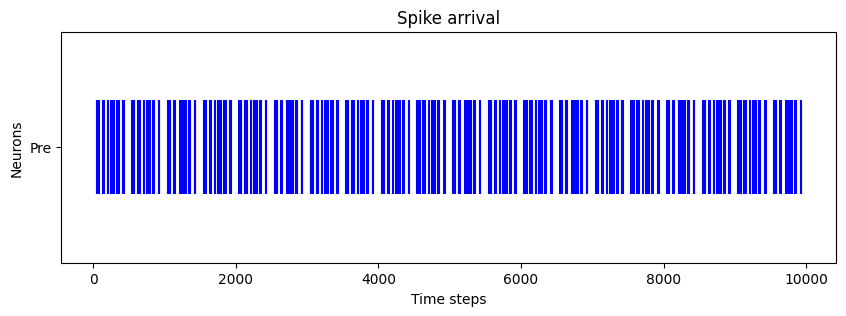

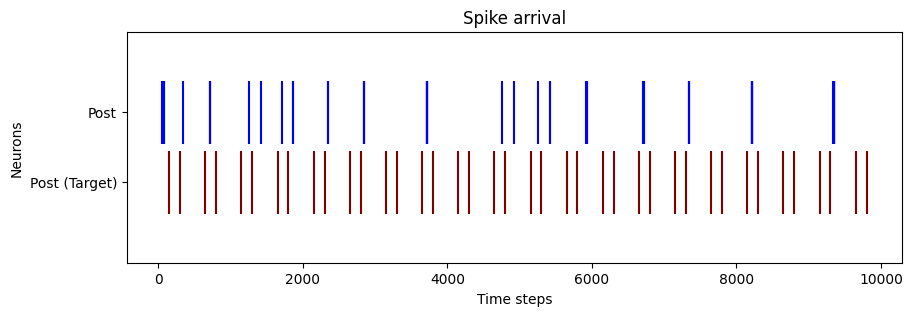

In [16]:
# Plot spikes
plot_spikes(spikes=[np.where(pre_spikes[:, 0])[0]], 
            legend=['Pre'], 
            colors=['blue'])

# Plot spikes
plot_spikes(spikes=[np.where(np.tile(spikes_raster_post_target[0], num_rounds))[0], np.where(post_spikes[:, 0])[0]], 
            legend=['Post (Target)', 'Post'], 
            colors=["maroon", 'blue'])

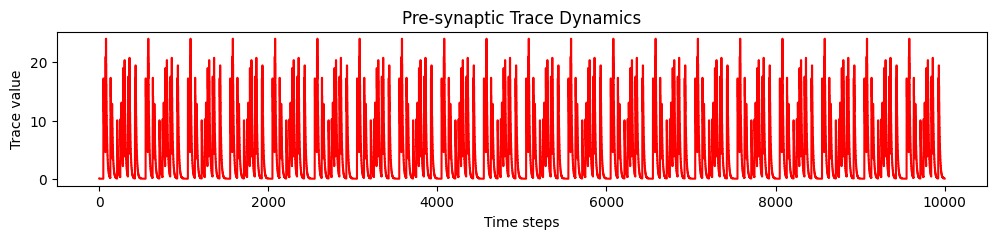

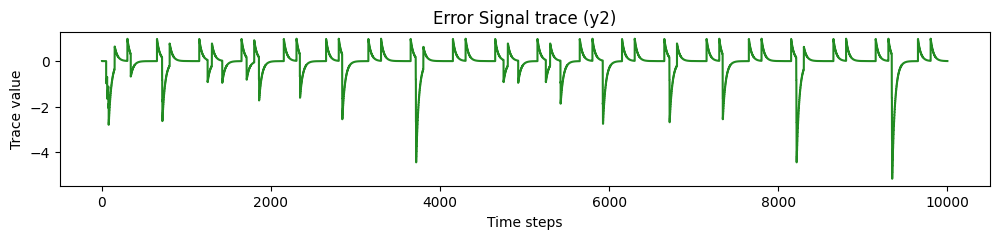

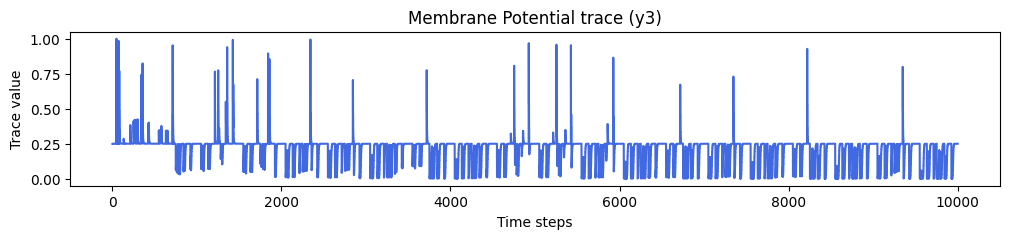

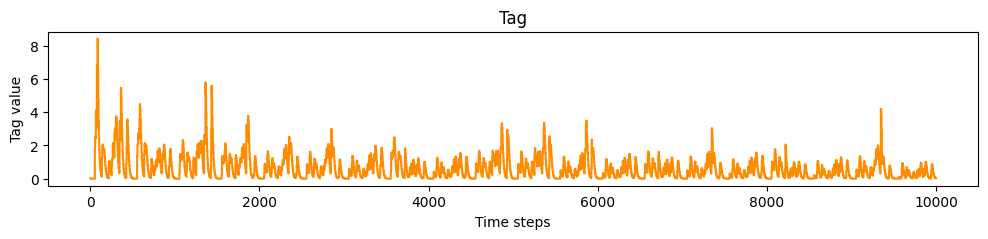

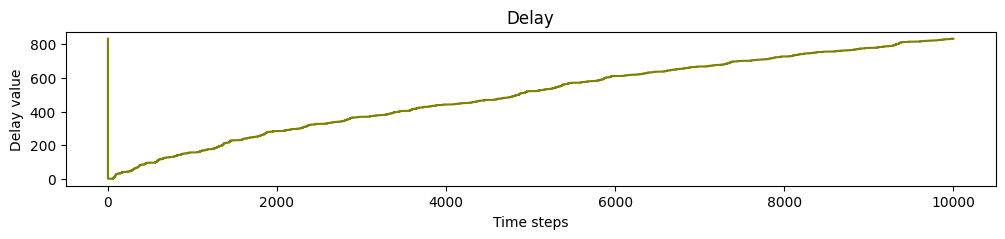

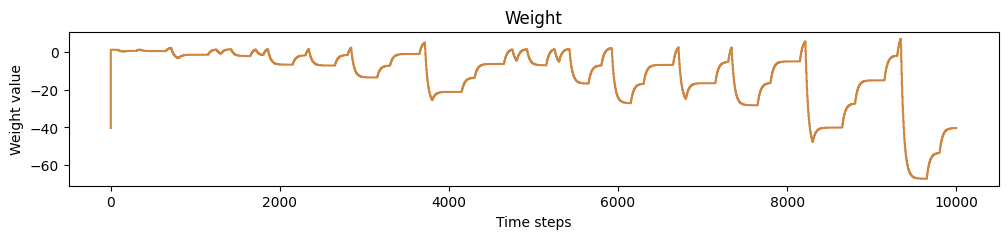

In [17]:
time = range(1, num_steps +1 )

plot_time_series(time=time, 
                 time_series=pre_trace, 
                 ylabel="Trace value", 
                 title="Pre-synaptic Trace Dynamics", 
                 figsize=(12, 2), 
                 color='red')

plot_time_series(time=time, 
                 time_series=y2_, 
                 ylabel="Trace value", 
                 title="Error Signal trace (y2)", 
                 figsize=(12, 2), 
                 color='forestgreen')

plot_time_series(time=time, 
                 time_series=y3_, 
                 ylabel="Trace value", 
                 title="Membrane Potential trace (y3)", 
                 figsize=(12, 2), 
                 color='royalblue')

plot_time_series(time=time, 
                 time_series=tag, 
                 ylabel="Tag value", 
                 title="Tag", 
                 figsize=(12, 2), 
                 color='darkorange')

plot_time_series(time=time, 
                 time_series=delay, 
                 ylabel="Delay value", 
                 title="Delay", 
                 figsize=(12, 2), 
                 color='olive')

plot_time_series(time=time, 
                 time_series=weights, 
                 ylabel="Weight value", 
                 title="Weight", 
                 figsize=(12, 2), 
                 color='peru')
